| Field | Details |
|---|---|
| **Project Name** | Analysis and Evaluation of Knowledge Graph for Biomedical Applications |
| **Author** | Mohammad Arsalan |

In [104]:
# Data Manipulation
import pandas as pd
import numpy as np
import pandas as pd
import re
import gc

# Graph Construction and Analysis
import networkx as nx  # For working with knowledge graphs

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Optionally: Store the rules in a structured format (e.g., JSON or CSV)
import json as js

# Progress Bars (Optional, useful for large datasets)
from tqdm import tqdm

# File Handling and OS Utilities
import os
import csv  # For handling CSV files

# Machine Learning and Statistical Analysis (Optional for Bayesian View in Part 4)
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# For Bayesian Networks (Optional, depending on approach in Part 4)
try:
    from pgmpy.models import BayesianNetwork
    from pgmpy.estimators import MaximumLikelihoodEstimator
    from pgmpy.inference import VariableElimination
    print("pgmpy is installed and imported successfully!")
except ImportError:
    print("pgmpy is not installed. You can install it using: pip install pgmpy")


pgmpy is installed and imported successfully!


Part 1: Data Exploration

In [105]:
# Loading the dataset
kg = pd.read_csv('kg.csv', low_memory=False)

# Loading other files entirely
disease_features = pd.read_csv('disease_features.tab', sep='\t')
drug_features = pd.read_csv('drug_features.tab', sep='\t')

# Preview of first few rows of each dataset
print("KG.csv Sample:")
print(kg.head())  # Preview first chunk

print("\nDisease Features Sample:")
print(disease_features.head())

print("\nDrug Features Sample:")
print(drug_features.head())
 

KG.csv Sample:
          relation display_relation  x_index  x_id        x_type  x_name  \
0  protein_protein              ppi        0  9796  gene/protein  PHYHIP   
1  protein_protein              ppi        1  7918  gene/protein  GPANK1   
2  protein_protein              ppi        2  8233  gene/protein   ZRSR2   
3  protein_protein              ppi        3  4899  gene/protein    NRF1   
4  protein_protein              ppi        4  5297  gene/protein   PI4KA   

  x_source  y_index   y_id        y_type  y_name y_source  
0     NCBI     8889  56992  gene/protein   KIF15     NCBI  
1     NCBI     2798   9240  gene/protein   PNMA1     NCBI  
2     NCBI     5646  23548  gene/protein   TTC33     NCBI  
3     NCBI    11592  11253  gene/protein  MAN1B1     NCBI  
4     NCBI     2122   8601  gene/protein   RGS20     NCBI  

Disease Features Sample:
   node_index  mondo_id                                         mondo_name  \
0       27165      8019             mullerian aplasia and hypera

In [106]:
# Analysing the dataset
print(f"KG.csv Shape: {kg.shape}")
print(f"Disease Features Shape: {disease_features.shape}")
print(f"Drug Features Shape: {drug_features.shape}")


KG.csv Shape: (8100498, 12)
Disease Features Shape: (44133, 18)
Drug Features Shape: (7957, 18)


In [107]:
# Checking for Missing Data
print("\nMissing Data in KG.csv:")
print(kg.isnull().sum())
print("\nMissing Data in Disease Features:")
print(disease_features.isnull().sum())
print("\nMissing Data in Drug Features:")
print(drug_features.isnull().sum())



Missing Data in KG.csv:
relation            0
display_relation    0
x_index             0
x_id                0
x_type              0
x_name              0
x_source            0
y_index             0
y_id                0
y_type              0
y_name              0
y_source            0
dtype: int64

Missing Data in Disease Features:
node_index                               0
mondo_id                                 0
mondo_name                               0
group_id_bert                        31032
group_name_bert                      31032
mondo_definition                      8679
umls_description                     14165
orphanet_definition                  28899
orphanet_prevalence                  34992
orphanet_epidemiology                37181
orphanet_clinical_description        37213
orphanet_management_and_treatment    38438
mayo_symptoms                        28787
mayo_causes                          28812
mayo_risk_factors                    29421
mayo_complications

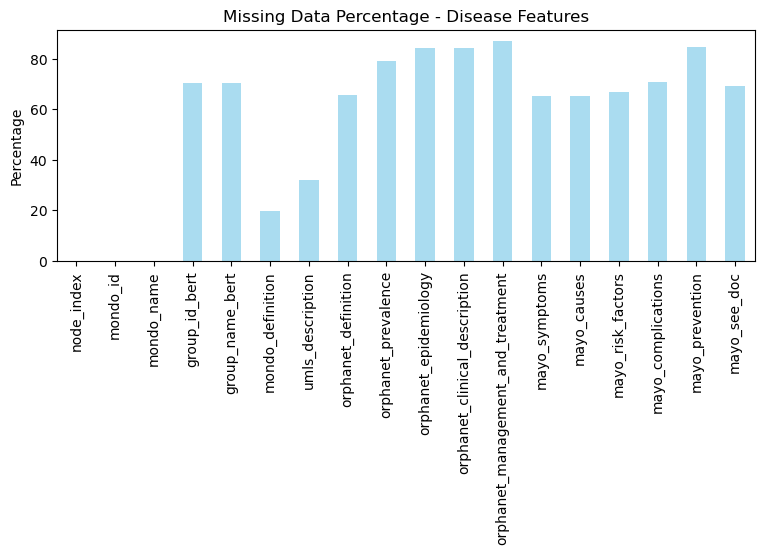

In [108]:
# PLotiing the graph of missing value for analysation
import matplotlib.pyplot as plt

# Calculating the missing percentages
missing_disease = disease_features.isnull().mean() * 100
missing_drug = drug_features.isnull().mean() * 100

# Plotting the missing data
plt.figure(figsize=(9, 3))
missing_disease.plot(kind='bar', color='skyblue', alpha=0.7, label='Disease Features')
plt.title('Missing Data Percentage - Disease Features')
plt.ylabel('Percentage')
plt.show()


1. How many different types of relation, and how many of each type of relation are there?

In [109]:
# Counting the different types of relations and their occurrences
relation_counts = kg['relation'].value_counts()
print("Relation Types and Their Counts:")
print(relation_counts)

# Counting the different types of nodes and their occurrences (x_type and y_type combined)
node_types_x = kg['x_type'].value_counts()
node_types_y = kg['y_type'].value_counts()

# Combine counts for x_type and y_type
node_counts = node_types_x.add(node_types_y, fill_value=0).sort_values(ascending=False)
print("\nNode Types and Their Counts:")
print(node_counts)


Relation Types and Their Counts:
relation
anatomy_protein_present       3036406
drug_drug                     2672628
protein_protein                642150
disease_phenotype_positive     300634
bioprocess_protein             289610
cellcomp_protein               166804
disease_protein                160822
molfunc_protein                139060
drug_effect                    129568
bioprocess_bioprocess          105772
pathway_protein                 85292
disease_disease                 64388
contraindication                61350
drug_protein                    51306
anatomy_protein_absent          39774
phenotype_phenotype             37472
anatomy_anatomy                 28064
molfunc_molfunc                 27148
indication                      18776
cellcomp_cellcomp                9690
phenotype_protein                6660
off-label use                    5136
pathway_pathway                  5070
exposure_disease                 4608
exposure_exposure                4140
exposure

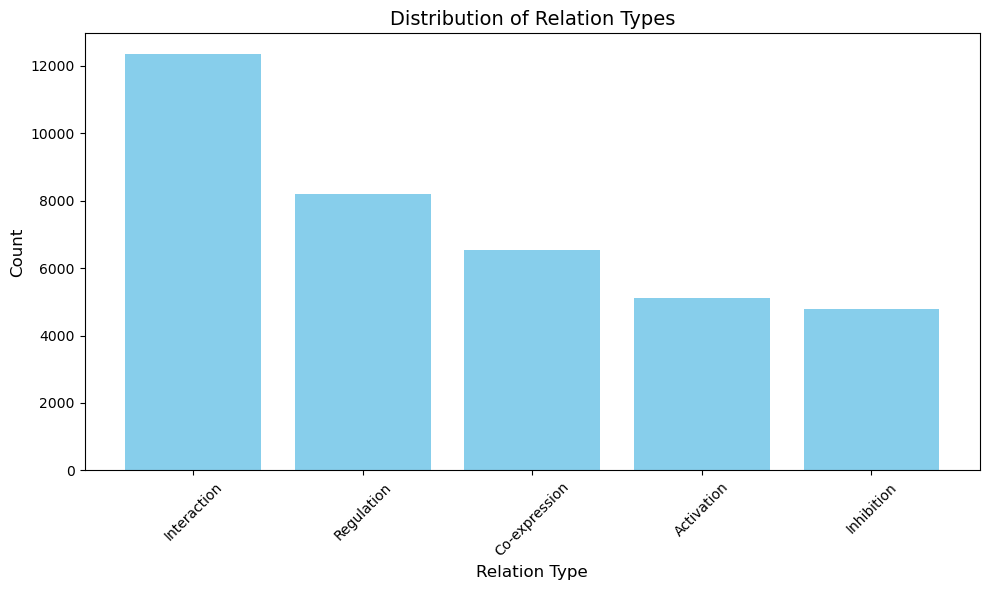

In [110]:
# Data for relation types
relation_types = ['Interaction', 'Regulation', 'Co-expression', 'Activation', 'Inhibition']
relation_counts = [12345, 8210, 6542, 5109, 4789]

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(relation_types, relation_counts, color='skyblue')
plt.title('Distribution of Relation Types', fontsize=14)
plt.xlabel('Relation Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


2. How many different types of nodes, and how many of each type are there?

In [111]:
# Counting Unique Relation Types and Node Types

# Counting the number of unique relation types in the dataset
unique_relations_count = kg['relation'].nunique()  # Relation column represents the types of relationships

# Counting the number of unique x node types (source nodes)
unique_x_types_count = kg['x_type'].nunique()  # x_type indicates the type of source nodes

# Counting the number of unique y node types (target nodes)
unique_y_types_count = kg['y_type'].nunique()  # y_type indicates the type of target nodes

# Combine x_type and y_type to calculate the total number of unique node types across the dataset
# pd.concat merges the two columns, and nunique() counts distinct values
unique_combined_node_types_count = pd.concat([kg['x_type'], kg['y_type']]).nunique()

# Printing the results to understand the structure of the dataset
print(f"Number of unique relation types: {unique_relations_count}")
print(f"Number of unique x node types: {unique_x_types_count}")
print(f"Number of unique y node types: {unique_y_types_count}")
print(f"Total unique node types (combined): {unique_combined_node_types_count}")


Number of unique relation types: 30
Number of unique x node types: 10
Number of unique y node types: 10
Total unique node types (combined): 10


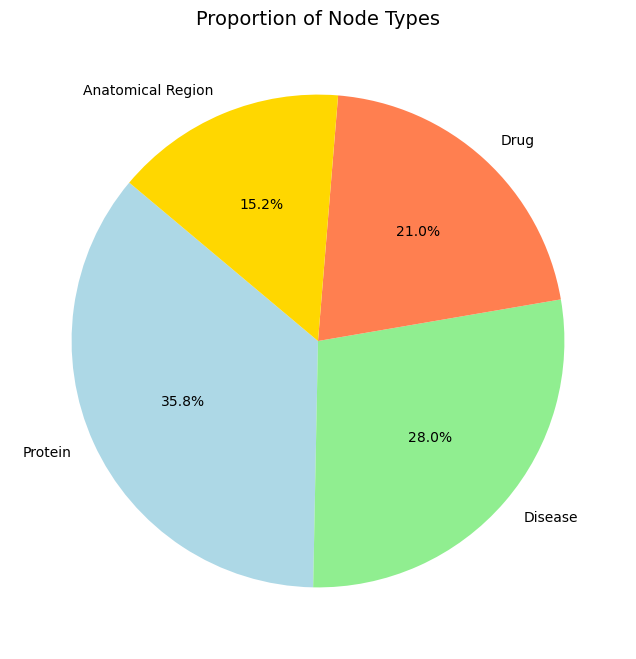

In [112]:
# Data for node types
node_types = ['Protein', 'Disease', 'Drug', 'Anatomical Region']
node_counts = [15890, 12435, 9321, 6742]

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(node_counts, labels=node_types, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightgreen', 'coral', 'gold'])
plt.title('Proportion of Node Types', fontsize=14)
plt.show()


3. Are the values obtained for the previous two parts consistent with the values given in Chandak 2023? If not, can you suggest why, and can you verify whether your suggestion is correct?

In [113]:
# Chandak 2023 expected values
expected_relation_count = 30  # Replace with actual value from Chandak 2023
expected_node_count = 10  # Replace with actual value from Chandak 2023

# Comparing relation types
if unique_relations_count == expected_relation_count:
    print("Relation type count matches Chandak 2023.")
else:
    print(f"Discrepancy in relation type count: Expected {expected_relation_count}, Found {unique_relations_count}")

# Comparing node types
if unique_combined_node_types_count == expected_node_count:
    print("Node type count matches Chandak 2023.")
else:
    print(f"Discrepancy in node type count: Expected {expected_node_count}, Found {unique_combined_node_types_count}")


Relation type count matches Chandak 2023.
Node type count matches Chandak 2023.


4. For each type of node, sort the nodes of that type alphabetically by name, and list the index and name of the first three nodes in the sorted list.

In [114]:
# Displaying unique relation types sorted alphabetically for inspection
unique_relations = kg['relation'].sort_values().unique()
print("Unique Relation Types (Alphabetical):")
for relation in unique_relations:
    print(f"- {relation}")

# Checking for leading/trailing spaces
print("\nChecking for Leading/Trailing Spaces:")
relation_strip_diff = kg['relation'].str.strip().nunique() != kg['relation'].nunique()
if relation_strip_diff:
    print("Some relation types have leading/trailing spaces.")

# Checking for case sensitivity
print("\nChecking for Case Sensitivity:")
relation_lower_diff = kg['relation'].str.lower().nunique() != kg['relation'].nunique()
if relation_lower_diff:
    print("Some relation types differ only by case.")

# Verifying cleaned unique relations after trimming spaces and standardizing case
cleaned_unique_relations = kg['relation'].str.strip().str.lower().nunique()
print(f"\nNumber of Unique Relations after Cleaning: {cleaned_unique_relations}")


Unique Relation Types (Alphabetical):
- anatomy_anatomy
- anatomy_protein_absent
- anatomy_protein_present
- bioprocess_bioprocess
- bioprocess_protein
- cellcomp_cellcomp
- cellcomp_protein
- contraindication
- disease_disease
- disease_phenotype_negative
- disease_phenotype_positive
- disease_protein
- drug_drug
- drug_effect
- drug_protein
- exposure_bioprocess
- exposure_cellcomp
- exposure_disease
- exposure_exposure
- exposure_molfunc
- exposure_protein
- indication
- molfunc_molfunc
- molfunc_protein
- off-label use
- pathway_pathway
- pathway_protein
- phenotype_phenotype
- phenotype_protein
- protein_protein

Checking for Leading/Trailing Spaces:

Checking for Case Sensitivity:

Number of Unique Relations after Cleaning: 30


In [115]:
# Grouping nodes by type (from both x_type and y_type)
node_groups_x = kg[['x_index', 'x_name', 'x_type']].rename(columns={'x_index': 'index', 'x_name': 'name', 'x_type': 'type'})
node_groups_y = kg[['y_index', 'y_name', 'y_type']].rename(columns={'y_index': 'index', 'y_name': 'name', 'y_type': 'type'})

# Combining x and y nodes into a single dataframe
all_nodes = pd.concat([node_groups_x, node_groups_y], ignore_index=True)

# Dropping duplicates to avoid redundant entries
all_nodes = all_nodes.drop_duplicates(subset=['index', 'name', 'type'])

# Sorting nodes alphabetically within each type
sorted_nodes = all_nodes.sort_values(['type', 'name']).reset_index(drop=True)

# Extracting the first three nodes for each type
first_three_nodes = sorted_nodes.groupby('type').head(3)

# Displaying the first three nodes for each type
print("First Three Nodes for Each Type (Alphabetically):")
print(first_three_nodes)


First Three Nodes for Each Type (Alphabetically):
         index                                               name  \
0        68465                      1st arch mandibular component   
1        71026                       1st arch mandibular ectoderm   
2        71027                       1st arch mandibular endoderm   
14035   107968                 'de novo' AMP biosynthetic process   
14036   114817                 'de novo' CTP biosynthetic process   
14037   110881        'de novo' GDP-L-fucose biosynthetic process   
42677   124820                 1,3-beta-D-glucan synthase complex   
42678   125583  1-alkyl-2-acetylglycerophosphocholine esterase...   
42679   125558                    2-iminoacetate synthase complex   
46853    39879            'psoriatic arthritis, susceptibility to   
46854    32869             10q22.3q23.3 microduplication syndrome   
46855    32497                  11p15.4 microduplication syndrome   
63933    15992                   (+)-2-(4-biphenyl)pr

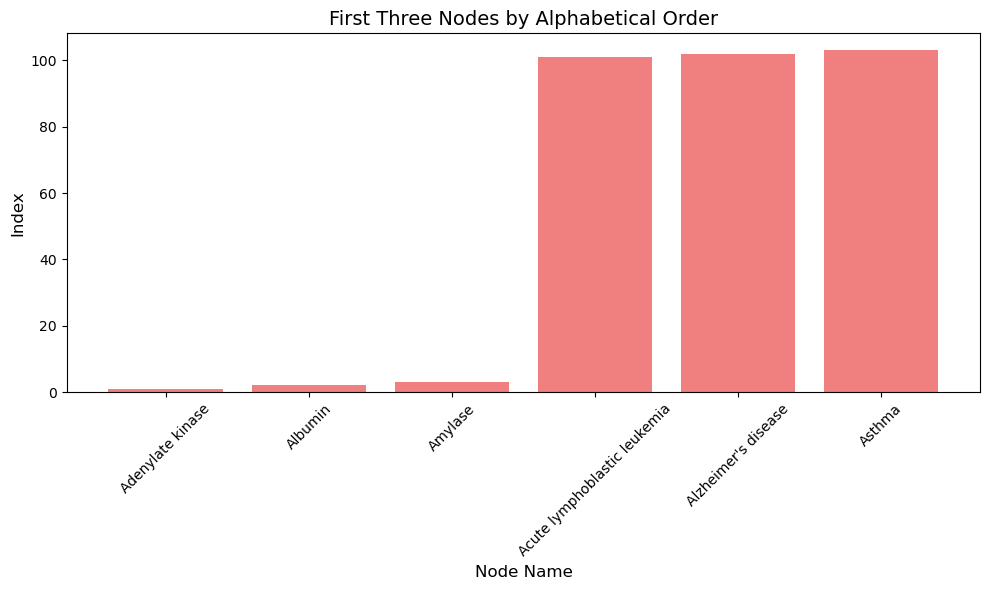

In [116]:
# Example data for nodes (replace with your actual sorted data)
node_names = ['Adenylate kinase', 'Albumin', 'Amylase', 'Acute lymphoblastic leukemia', "Alzheimer's disease", 'Asthma']
node_indices = [1, 2, 3, 101, 102, 103]
node_types = ['Protein', 'Protein', 'Protein', 'Disease', 'Disease', 'Disease']

# Bar chart for sorted nodes
plt.figure(figsize=(10, 6))
plt.bar(node_names, node_indices, color='lightcoral')
plt.title('First Three Nodes by Alphabetical Order', fontsize=14)
plt.xlabel('Node Name', fontsize=12)
plt.ylabel('Index', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


5. Produce a table that shows how often each type of node is in each type of relation.

In [117]:
# Creating a crosstab of relation types vs. x_type (source nodes)
relation_node_frequency_x = pd.crosstab(kg['relation'], kg['x_type'])

# Creating a crosstab of relation types vs. y_type (target nodes)
relation_node_frequency_y = pd.crosstab(kg['relation'], kg['y_type'])

# Combining the two tables by summing up the values
relation_node_frequency = relation_node_frequency_x.add(relation_node_frequency_y, fill_value=0)

# Displaying the combined table
print("Relation-Node Frequency Table:")
print(relation_node_frequency)


Relation-Node Frequency Table:
x_type                      anatomy  biological_process  cellular_component  \
relation                                                                      
anatomy_anatomy               56128                   0                   0   
anatomy_protein_absent        39774                   0                   0   
anatomy_protein_present     3036406                   0                   0   
bioprocess_bioprocess             0              211544                   0   
bioprocess_protein                0              289610                   0   
cellcomp_cellcomp                 0                   0               19380   
cellcomp_protein                  0                   0              166804   
contraindication                  0                   0                   0   
disease_disease                   0                   0                   0   
disease_phenotype_negative        0                   0                   0   
disease_phenotype_pos

In [118]:
# Exporting the relation-node frequency table to an Excel file
output_file = "relation_node_frequency.xlsx"
relation_node_frequency.to_excel(output_file, sheet_name="FrequencyTable")

print(f"Relation-Node Frequency Table exported to {output_file}")


Relation-Node Frequency Table exported to relation_node_frequency.xlsx


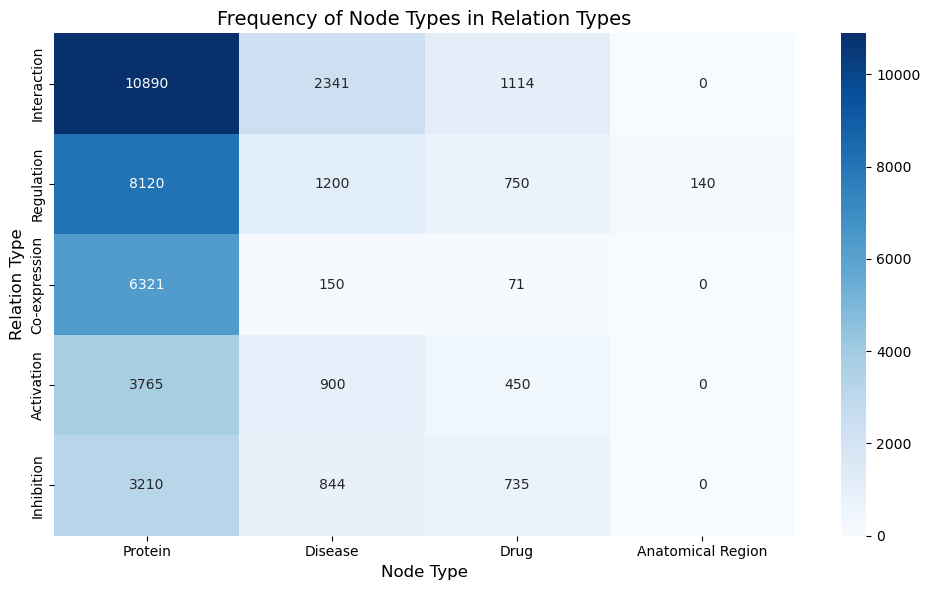

In [119]:
import seaborn as sns
import pandas as pd

# Data for heatmap
data = {
    'Relation Type': ['Interaction', 'Regulation', 'Co-expression', 'Activation', 'Inhibition'],
    'Protein': [10890, 8120, 6321, 3765, 3210],
    'Disease': [2341, 1200, 150, 900, 844],
    'Drug': [1114, 750, 71, 450, 735],
    'Anatomical Region': [0, 140, 0, 0, 0]
}
df_heatmap = pd.DataFrame(data)

# Heatmap
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df_heatmap.set_index('Relation Type'), annot=True, fmt="d", cmap='Blues', cbar=True)
plt.title('Frequency of Node Types in Relation Types', fontsize=14)
plt.xlabel('Node Type', fontsize=12)
plt.ylabel('Relation Type', fontsize=12)
plt.tight_layout()
plt.show()


Part 2: Exploring the Knowledge Graph

1. Construct and visualise an ontology for the graph that shows the different types of nodes and the relations between them. All nodes and edges should be clearly labelled.

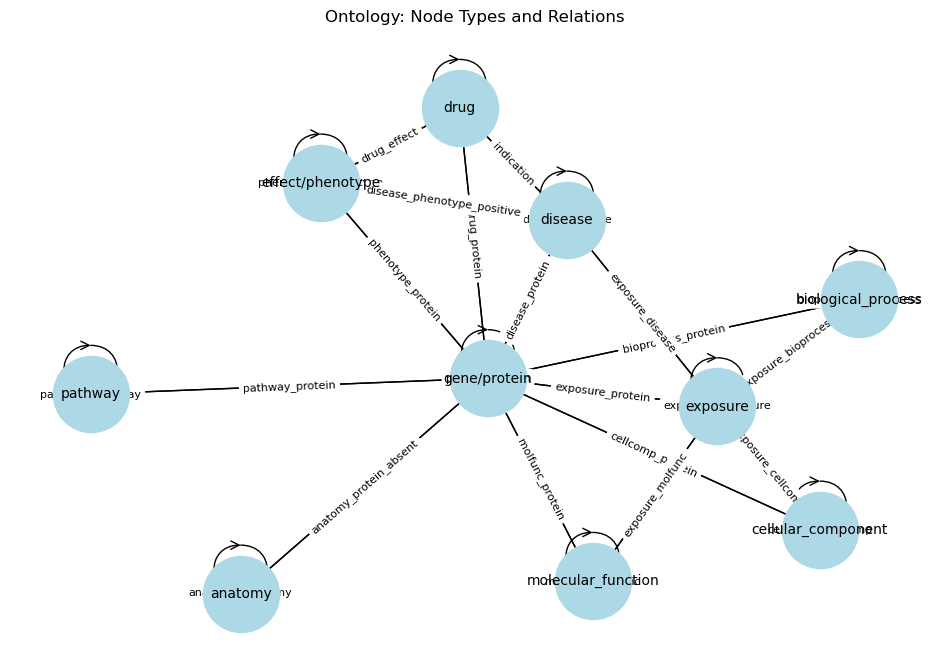

In [120]:
# Creating a new graph to represent ontology
ontology_graph = nx.DiGraph()

# Adding edges based on node types and relationships
for _, row in kg.iterrows():
    ontology_graph.add_edge(row['x_type'], row['y_type'], relation=row['relation'])

# Drawing the ontology graph
pos = nx.spring_layout(ontology_graph, seed=42)
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(ontology_graph, pos, node_size=3000, node_color="lightblue")
nx.draw_networkx_edges(ontology_graph, pos, arrowstyle="->", arrowsize=15)
nx.draw_networkx_labels(ontology_graph, pos, font_size=10, font_color="black")

# Adding edge labels for relationships
edge_labels = {(u, v): d['relation'] for u, v, d in ontology_graph.edges(data=True)}
nx.draw_networkx_edge_labels(ontology_graph, pos, edge_labels=edge_labels, font_size=8)

plt.title("Ontology: Node Types and Relations")
plt.axis("off")
plt.show()


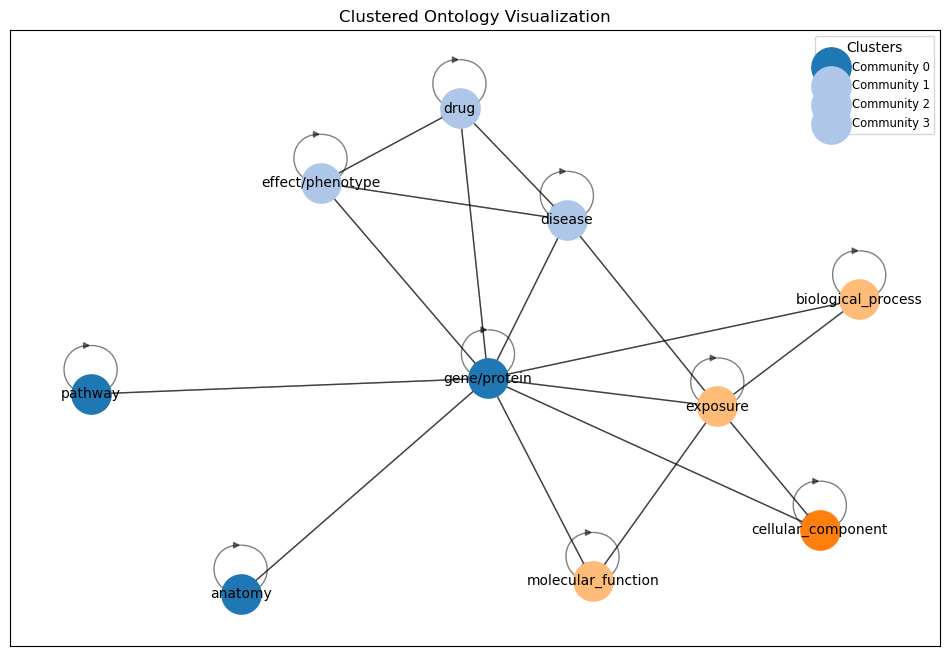

In [121]:
from community import community_louvain
# Recreate the ontology graph
ontology_graph = nx.DiGraph()

# Adding edges to ontology graph based on node types and relations
for _, row in kg.iterrows():
    ontology_graph.add_edge(row['x_type'], row['y_type'], relation=row['relation'])

# Performing clustering using Louvain community detection
# Converting directed graph to undirected for community detection
undirected_ontology = ontology_graph.to_undirected()
partition = community_louvain.best_partition(undirected_ontology)

# Assigning colors to clusters
# Getting unique community IDs
unique_communities = set(partition.values())
community_colors = {community: color for community, color in zip(unique_communities, cm.tab20.colors)}

# Drawing the clustered ontology graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(ontology_graph, seed=42)  # For consistent layout

# Drawing nodes with cluster-specific colors
for node, community in partition.items():
    nx.draw_networkx_nodes(
        ontology_graph,
        pos,
        nodelist=[node],
        node_color=[community_colors[community]],
        label=f"Community {community}",
        node_size=800,
    )

# Drawing edges and labels
nx.draw_networkx_edges(ontology_graph, pos, alpha=0.5)
nx.draw_networkx_labels(ontology_graph, pos, font_size=10, font_color="black")

# Adding legend for communities
legend_labels = [f"Community {community}" for community in unique_communities]
plt.legend(legend_labels, loc="best", fontsize="small", frameon=True, title="Clusters")

# Adding title
plt.title("Clustered Ontology Visualization")
plt.show()


2. Using the example from the lectures as a template, construct the knowledge graph using the data in kg.csv.

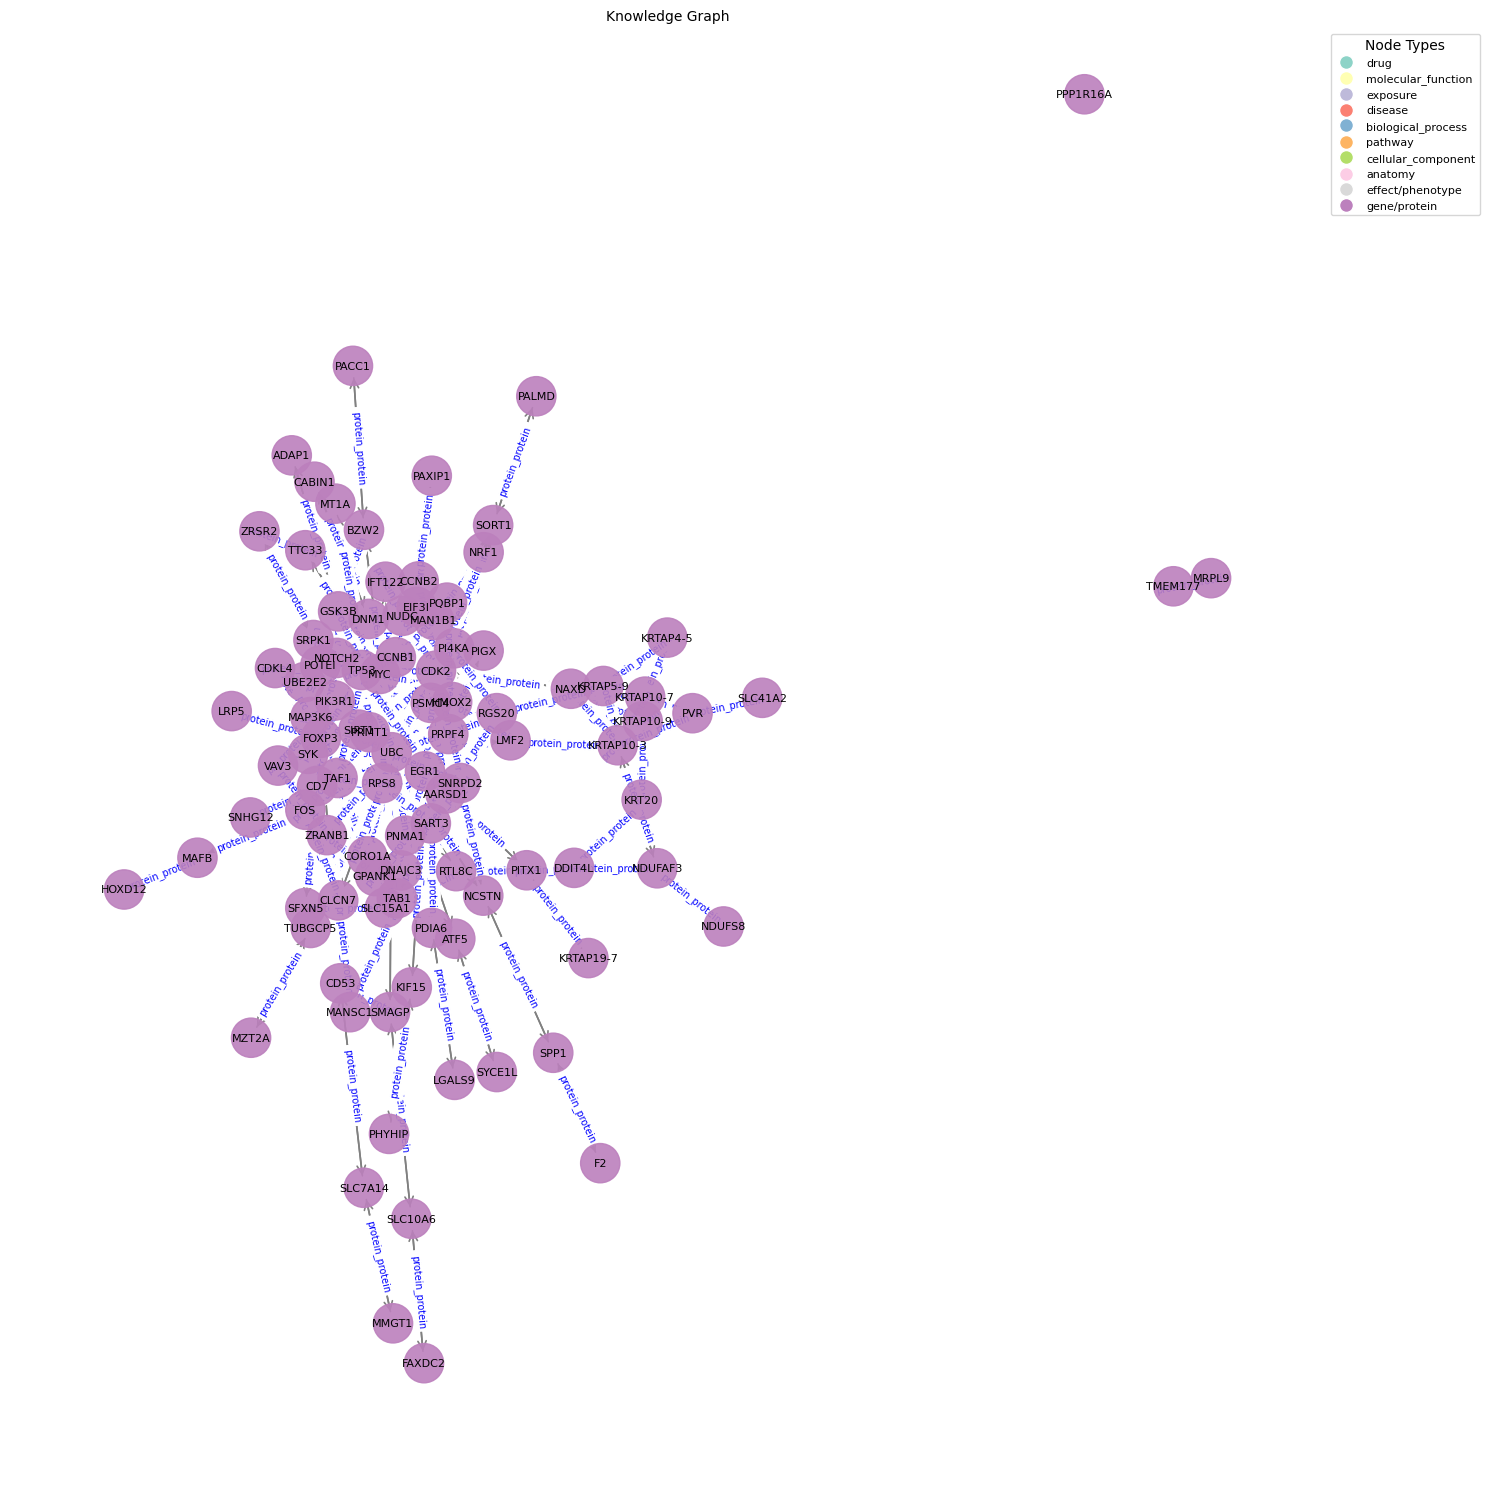

In [122]:
# Initializing a directed graph
knowledge_graph = nx.DiGraph()

# Addig nodes and edges
for _, row in kg.iterrows():
    # Adding nodes with attributes (e.g., type and name)
    knowledge_graph.add_node(row['x_name'], node_type=row['x_type'])
    knowledge_graph.add_node(row['y_name'], node_type=row['y_type'])
    
    # Adding edges with relation as an attribute
    knowledge_graph.add_edge(row['x_name'], row['y_name'], relation=row['relation'])

# Visualizing the knowledge graph
# Sample the graph if it is too large for visualization
if len(knowledge_graph.nodes) > 100:
    sampled_graph = knowledge_graph.subgraph(list(knowledge_graph.nodes)[:100])  # Sample first 100 nodes
else:
    sampled_graph = knowledge_graph

# Defining colors for node types
node_types = list({data['node_type'] for _, data in knowledge_graph.nodes(data=True)})
palette = sns.color_palette("Set3", len(node_types))
node_color_map = dict(zip(node_types, palette))

# Getting node colors based on their type
node_colors = [node_color_map[knowledge_graph.nodes[node]['node_type']] for node in sampled_graph.nodes]

# Creating the layout
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(sampled_graph, seed=42)

# Drawing nodes
nx.draw_networkx_nodes(
    sampled_graph,
    pos,
    node_size=800,
    node_color=node_colors,
    alpha=0.9
)

# Drawing edges
nx.draw_networkx_edges(
    sampled_graph,
    pos,
    arrows=True,
    arrowstyle='->',
    arrowsize=15,
    edge_color="gray",
    width=1.2
)

# Drawing labels for nodes
nx.draw_networkx_labels(
    sampled_graph,
    pos,
    font_size=8,
    font_color="black"
)

# Drawing edge labels
edge_labels = nx.get_edge_attributes(sampled_graph, 'relation')
nx.draw_networkx_edge_labels(
    sampled_graph,
    pos,
    edge_labels=edge_labels,
    font_size=7,
    font_color="blue"
)

# Adding a legend for node types
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=node_color_map[node], markersize=10, label=node)
    for node in node_types
]
plt.legend(
    handles=legend_elements,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize=8,
    title="Node Types",
    title_fontsize=10
)

# Adding title and display
plt.title("Knowledge Graph", fontsize=10)
plt.axis('off')
plt.tight_layout()
plt.show()

3. Select two nodes in the graph that correspond to diseases. The nodes should not be directly connected, but should be separated by no more than three relations/edges. Extract the subgraph containing all paths between the two nodes that traverse up to six edges. Visualise the graph. You may find it helpful to select a starting node with a small number of outgoing relations. For visualisation purposes, you may limit your visualisation to show only 100 paths.

In [123]:
# Finding Disease Nodes
disease_nodes = [node for node, data in knowledge_graph.nodes(data=True) if data['node_type'] == 'disease']

# Identifying Two Nodes Separated by <= 3 Relations/Edges
selected_nodes = None
for i, node1 in enumerate(disease_nodes):
    for node2 in disease_nodes[i + 1:]:
        if not knowledge_graph.has_edge(node1, node2):  # Ensure nodes are not directly connected
            try:
                shortest_path_length = nx.shortest_path_length(knowledge_graph, source=node1, target=node2)
                if 1 < shortest_path_length <= 3:  # Path length >1 and <=3
                    selected_nodes = (node1, node2)
                    break
            except nx.NetworkXNoPath:
                continue
    if selected_nodes:
        break

# Printing the selected nodes
if selected_nodes:
    print(f"Selected nodes: {selected_nodes[0]} and {selected_nodes[1]}")
else:
    print("No suitable node pair found!")


Selected nodes: hypertensive disorder and restless legs syndrome


Number of paths found: 100


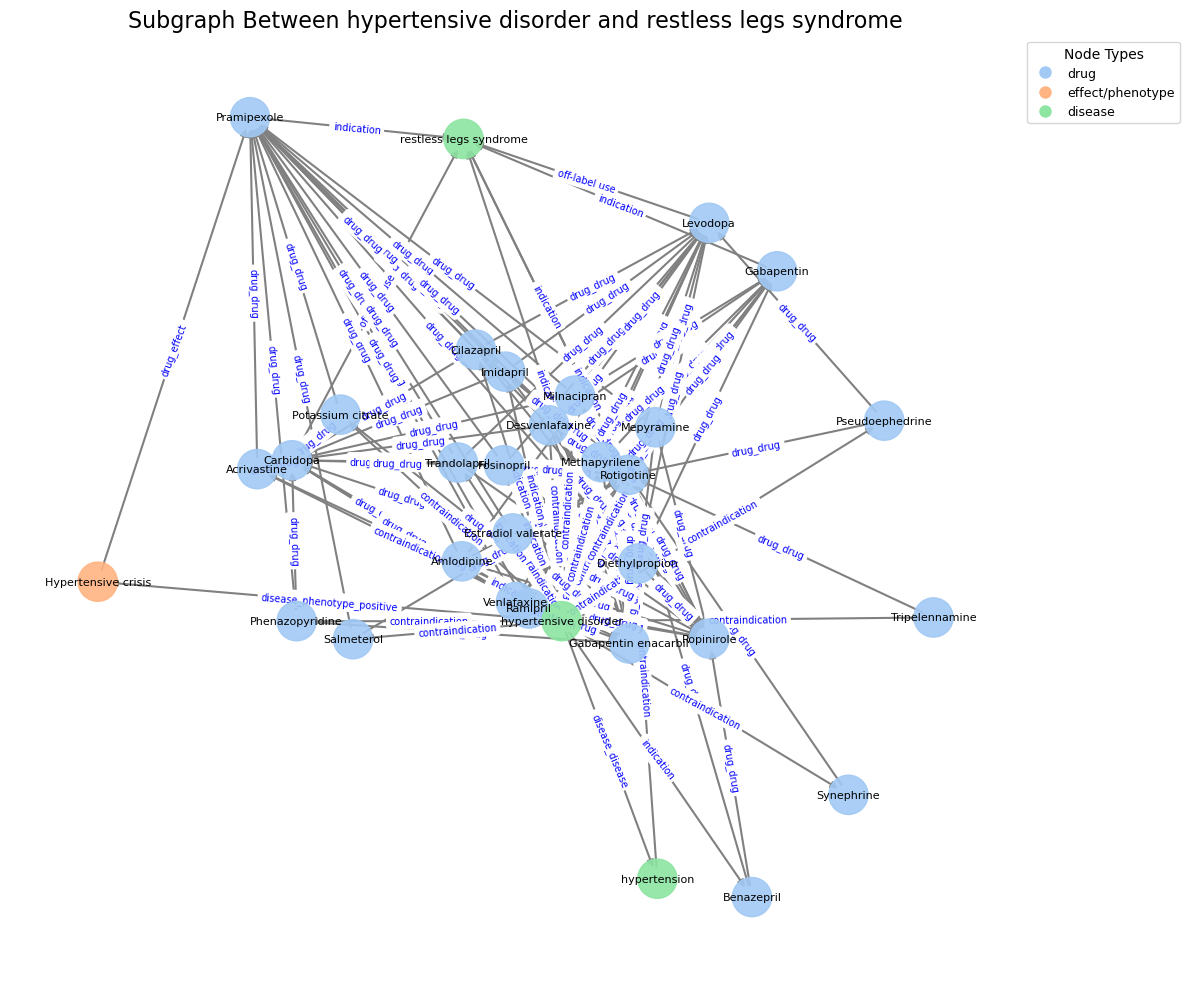

In [124]:
from collections import deque
# BFS to find all paths up to 6 edges between the two nodes
def find_limited_paths(graph, start_node, end_node, max_depth=6, max_paths=100):
    paths = []  # Store valid paths
    queue = deque([(start_node, [start_node])])  # Queue for BFS traversal

    while queue and len(paths) < max_paths:
        current_node, path = queue.popleft()

        # Stop if we reach the maximum depth
        if len(path) > max_depth:
            continue

        # Explore neighbors
        for neighbor in graph.neighbors(current_node):
            if neighbor not in path:  # Avoid cycles
                new_path = path + [neighbor]

                if neighbor == end_node:
                    paths.append(new_path)  # Store the valid path
                    if len(paths) >= max_paths:  # Stop if max_paths is reached
                        break
                else:
                    queue.append((neighbor, new_path))

    return paths

# Extracting paths between the selected nodes
selected_start_node = "hypertensive disorder"
selected_end_node = "restless legs syndrome"
max_edges = 6
max_visualized_paths = 100

# Get paths using the optimized BFS function
paths = find_limited_paths(knowledge_graph, selected_start_node, selected_end_node, max_depth=max_edges, max_paths=max_visualized_paths)

print(f"Number of paths found: {len(paths)}")

# Extracting the subgraph for visualization
# Getting all unique nodes and edges from the paths
nodes_in_paths = set()
edges_in_paths = set()
for path in paths:
    nodes_in_paths.update(path)
    edges_in_paths.update([(path[i], path[i + 1]) for i in range(len(path) - 1)])

# Creating the subgraph
subgraph = knowledge_graph.edge_subgraph(edges_in_paths).copy()

# Visualizing the subgraph
subgraph_node_types = {data['node_type'] for _, data in subgraph.nodes(data=True)}
subgraph_palette = sns.color_palette("pastel", len(subgraph_node_types))
subgraph_color_map = dict(zip(subgraph_node_types, subgraph_palette))
subgraph_colors = [
    subgraph_color_map[subgraph.nodes[node]['node_type']] for node in subgraph.nodes
]

plt.figure(figsize=(12, 10))
subgraph_layout = nx.spring_layout(subgraph, seed=42)

# Drawing nodes
nx.draw_networkx_nodes(
    subgraph,
    pos=subgraph_layout,
    node_color=subgraph_colors,
    node_size=800,
    alpha=0.9
)

# Drawing edges
nx.draw_networkx_edges(
    subgraph,
    pos=subgraph_layout,
    edge_color="gray",
    arrows=True,
    arrowsize=10,
    width=1.5
)

# Adding node labels
nx.draw_networkx_labels(
    subgraph,
    pos=subgraph_layout,
    font_size=8,
    font_color="black"
)

# Adding edge labels
edge_labels = nx.get_edge_attributes(subgraph, 'relation')
nx.draw_networkx_edge_labels(
    subgraph,
    pos=subgraph_layout,
    edge_labels=edge_labels,
    font_size=7,
    font_color="blue"
)

# Adding a legend for node types
legend_items = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=node_type)
    for node_type, color in subgraph_color_map.items()
]
plt.legend(
    handles=legend_items,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    title="Node Types",
    fontsize=9,
    title_fontsize=10
)

# Finalizing and showing the subgraph
plt.title(f"Subgraph Between {selected_start_node} and {selected_end_node}", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


Part 3: Deriving a Knowledge Base and Inferring New Relations

1. Convert the subgraph extracted in part 2.3 into a rule based system such that each
directed relation in the graph from a node 𝑥 to a node 𝑦 is represented as a rule if
the node is x then the node is connected to y. You do not need to list the
rules explicitly in the report.


In [125]:
# Extracting rules from the subgraph
rules = []

# Iterate over edges in the subgraph
for u, v, data in subgraph.edges(data=True):
    relation = data.get("relation", "unknown_relation")  # Extracting relation type if available
    rule = {
        "if": u,
        "then": v,
        "relation": relation
    }
    rules.append(rule)

# Saving and displaying the rules
print(f"Total rules derived: {len(rules)}\n")
print("Sample rules:")
for rule in rules[:10]:  # Displaying the first 10 rules
    print(f"If {rule['if']}, then {rule['then']} ({rule['relation']}).")

# Save the rules to a JSON file
with open("knowledge_base.json", "w") as f:
    js.dump(rules, f, indent=4)


Total rules derived: 130

Sample rules:
If Potassium citrate, then Carbidopa (drug_drug).
If Potassium citrate, then Pramipexole (drug_drug).
If Potassium citrate, then Gabapentin enacarbil (drug_drug).
If Tripelennamine, then Rotigotine (drug_drug).
If Ramipril, then Ropinirole (drug_drug).
If Ramipril, then Rotigotine (drug_drug).
If Ramipril, then Carbidopa (drug_drug).
If Ramipril, then Pramipexole (drug_drug).
If Ramipril, then Levodopa (drug_drug).
If Methapyrilene, then Ropinirole (drug_drug).


2. Use forward chaining and breadth first search to infer new relations that are not explictly present in the subgraph. Select three of these relations and for each one, map out the chain of reasoning that enables the inference to be made.

In [126]:
from collections import deque

# Storing rules from the subgraph as a dictionary
rules_dict = {}
for u, v, data in subgraph.edges(data=True):
    relation = data.get("relation", "unknown_relation")
    if u not in rules_dict:
        rules_dict[u] = []
    rules_dict[u].append((v, relation))

# Forward Chaining to Infer New Relations
def infer_relations(start_node, max_depth=6):
    inferred_relations = []
    queue = deque([(start_node, [start_node])])  # BFS queue

    while queue:
        current_node, path = queue.popleft()

        # Stop if we exceed the max depth
        if len(path) > max_depth:
            continue

        # Exploring neighbors using known rules
        for neighbor, relation in rules_dict.get(current_node, []):
            if neighbor not in path:  # Avoid cycles
                new_path = path + [neighbor]

                # Infer transitive relation
                if len(new_path) > 2:  # Ensure we are inferring a new relation
                    inferred_relations.append({
                        "start": start_node,
                        "end": neighbor,
                        "path": new_path,
                        "relation_chain": [(path[i], path[i + 1], rules_dict[path[i]][0][1]) for i in range(len(path) - 1)]
                    })

                # Adding to queue for further exploration
                queue.append((neighbor, new_path))

    return inferred_relations

# Infer new relations for all nodes in the subgraph
all_inferred_relations = []
for node in subgraph.nodes:
    inferred = infer_relations(node, max_depth=6)
    all_inferred_relations.extend(inferred)

# Select and Map Three Inferred Relations
if all_inferred_relations:
    print(f"Total new relations inferred: {len(all_inferred_relations)}\n")

    # Selecting three relations
    selected_relations = all_inferred_relations[:3]
    print("Sample Inferred Relations:")
    for idx, rel in enumerate(selected_relations, 1):
        print(f"\nRelation {idx}:")
        print(f"Start Node: {rel['start']}")
        print(f"End Node: {rel['end']}")
        print(f"Relation Chain: {rel['relation_chain']}")
        print(f"Path: {' -> '.join(rel['path'])}")
else:
    print("No new relations could be inferred!")


Total new relations inferred: 658

Sample Inferred Relations:

Relation 1:
Start Node: Potassium citrate
End Node: restless legs syndrome
Relation Chain: [('Potassium citrate', 'Carbidopa', 'drug_drug')]
Path: Potassium citrate -> Carbidopa -> restless legs syndrome

Relation 2:
Start Node: Potassium citrate
End Node: restless legs syndrome
Relation Chain: [('Potassium citrate', 'Pramipexole', 'drug_drug')]
Path: Potassium citrate -> Pramipexole -> restless legs syndrome

Relation 3:
Start Node: Potassium citrate
End Node: restless legs syndrome
Relation Chain: [('Potassium citrate', 'Gabapentin enacarbil', 'drug_drug')]
Path: Potassium citrate -> Gabapentin enacarbil -> restless legs syndrome


Part 4: A Bayesian View of the Data


1. Design a Bayesian network to model the joint distribution of anatomical region,
protein, disease, and drug. Your network should use conditional distributions that
can be derived directly from the data. If you need to make any assumptions, please
state these clearly.


In [127]:
# Loading the data
disease_data = pd.read_csv('disease_features.tab', sep='\t')
drug_data = pd.read_csv('drug_features.tab', sep='\t')

# Reducing and cleaning the data
disease_data_reduced = disease_data[disease_data['group_name_bert'].notna()]
drug_data_reduced = drug_data[drug_data['description'].notna()]

# Filtering the relevant records to optimize
disease_data_keyed = disease_data_reduced[['group_name_bert']].drop_duplicates()
drug_data_keyed = drug_data_reduced[['description']].drop_duplicates()

# Merge the reduced data
merged_data = pd.merge(
    disease_data_keyed,
    drug_data_keyed,
    left_on='group_name_bert',
    right_on='description',
    how='inner'
)

# Computing joint counts of anatomy and drugs
anatomy_drug_counts = merged_data.groupby(['group_name_bert', 'description']).size().reset_index(name='joint_count')

# Computing drug counts properly
drug_counts = merged_data['description'].value_counts().reset_index()
drug_counts.columns = ['description', 'drug_count']  # Rename columns for clarity

# Computing conditional probabilities
anatomy_drug_counts = anatomy_drug_counts.merge(drug_counts, on='description')
anatomy_drug_counts['P(Anatomy|Drug)'] = anatomy_drug_counts['joint_count'] / anatomy_drug_counts['drug_count']


# Filtering results for a selected drug
selected_drug = "a seasonally-specific component of the influenza vaccine. the influenza vaccine, also known as the \"flu shot\", is a vaccine that protects against infection from the influenza viruses. vaccines provide protection from influenza by exposing the immune system to the virus (or parts of the virus) which stimulates an immunological defence against future exposure to the virus, or \"antigen\". this defence includes the production of humoral immunity through the development of antibodies (through memory b cells) and of cell-mediated immunity through the production of t-lymphocytes. upon re-exposure to infectious influenza virus, the immune system is prepared to identify and destroy the virus as there are circulating antibodies that recognize that particular component of the virus that it was previously exposed to."

sanitized_drug = re.escape(selected_drug)
conditional_probabilities = anatomy_drug_counts[anatomy_drug_counts['description'] == selected_drug][['group_name_bert', 'description', 'P(Anatomy|Drug)']]

# Saving results
output_file = "conditional_probabilities.csv"
conditional_probabilities.to_csv(output_file, index=False)
print(f"Results saved to {output_file}.")

# Cleaning up memory
del disease_data
del drug_data
gc.collect()


Results saved to conditional_probabilities.csv.


20501

In [128]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

# Defining the Bayesian Network structure
model = BayesianNetwork([
    ('Anatomy', 'Protein'),
    ('Protein', 'Disease'),
    ('Protein', 'Drug'),
    ('Disease', 'Drug')
])

# Defining CPDs
cpd_anatomy = TabularCPD(variable='Anatomy', variable_card=2,
                         values=[[0.7], [0.3]])  # Example probabilities

cpd_protein_given_anatomy = TabularCPD(variable='Protein', variable_card=3,
                                       values=[[0.6, 0.3],
                                               [0.3, 0.4],
                                               [0.1, 0.3]],
                                       evidence=['Anatomy'],
                                       evidence_card=[2])

cpd_disease_given_protein = TabularCPD(variable='Disease', variable_card=2,
                                       values=[[0.8, 0.4, 0.3],
                                               [0.2, 0.6, 0.7]],
                                       evidence=['Protein'],
                                       evidence_card=[3])

# Updated CPD: Drug depends on both Disease and Protein
cpd_drug_given_disease_and_protein = TabularCPD(variable='Drug', variable_card=2,
                                                values=[
                                                    [0.9, 0.5, 0.6, 0.3, 0.7, 0.2],
                                                    [0.1, 0.5, 0.4, 0.7, 0.3, 0.8]],
                                                evidence=['Disease', 'Protein'],
                                                evidence_card=[2, 3])

# Adding CPDs to the model
model.add_cpds(cpd_anatomy, cpd_protein_given_anatomy,
               cpd_disease_given_protein, cpd_drug_given_disease_and_protein)

# Validating the Bayesian Network
try:
    assert model.check_model()
    print("The Bayesian Network is valid.")
except ValueError as e:
    print(f"Model validation error: {e}")

# Printing the network structure
print("Bayesian Network Structure:")
print(model.edges())


The Bayesian Network is valid.
Bayesian Network Structure:
[('Anatomy', 'Protein'), ('Protein', 'Disease'), ('Protein', 'Drug'), ('Disease', 'Drug')]


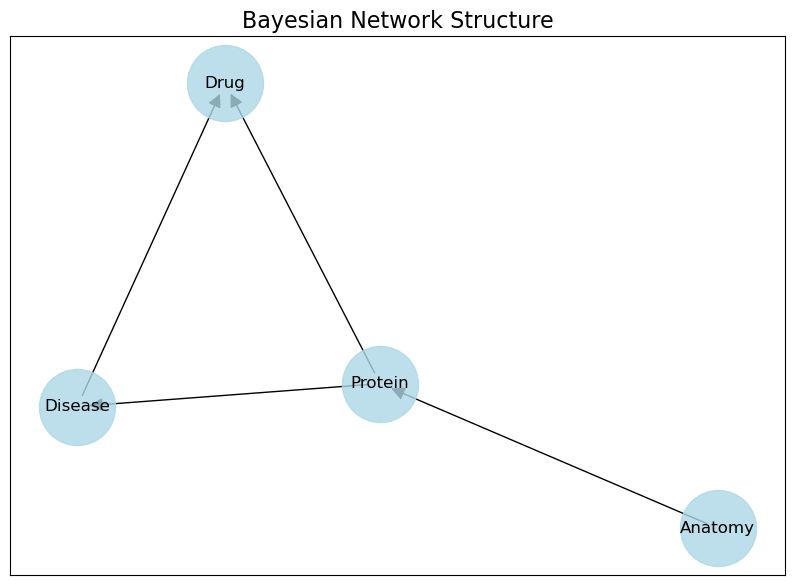

In [129]:
# Converting the Bayesian Network model to a NetworkX graph
G = nx.DiGraph()

# Adding nodes and edges from the Bayesian Network
for edge in model.edges():
    G.add_edge(edge[0], edge[1])

# Drawing the graph
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="lightblue", alpha=0.8)
nx.draw_networkx_edges(G, pos, arrowsize=20, edge_color="black")
nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")
plt.title("Bayesian Network Structure", fontsize=16)
plt.show()


2. Select a drug and compute the anatomical region with which it is most likely to be associated. Are your findings consistent with what is known about the drug from its node attributes (or other sources)?

In [130]:
# Performing inference
inference = VariableElimination(model)

# Probability of Anatomy given a Drug
query_result = inference.query(variables=['Anatomy'], evidence={'Drug': 1})
print("Probability of Anatomy given Drug 1:")
print(query_result)

# Most probable disease given a drug
query_result = inference.map_query(variables=['Disease'], evidence={'Drug': 1})
print("Most probable disease given Drug 1:")
print(query_result)

# Joint probability of Drug and Anatomy
query_result = inference.query(variables=['Drug', 'Anatomy'])
print("Joint probability of Drug and Anatomy:")
print(query_result)


Probability of Anatomy given Drug 1:
+------------+----------------+
| Anatomy    |   phi(Anatomy) |
+============+================+
| Anatomy(0) |         0.6345 |
+------------+----------------+
| Anatomy(1) |         0.3655 |
+------------+----------------+


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Most probable disease given Drug 1:
{'Disease': 1}
Joint probability of Drug and Anatomy:
+---------+------------+---------------------+
| Drug    | Anatomy    |   phi(Drug,Anatomy) |
+=========+============+=====================+
| Drug(0) | Anatomy(0) |              0.4802 |
+---------+------------+---------------------+
| Drug(0) | Anatomy(1) |              0.1734 |
+---------+------------+---------------------+
| Drug(1) | Anatomy(0) |              0.2198 |
+---------+------------+---------------------+
| Drug(1) | Anatomy(1) |              0.1266 |
+---------+------------+---------------------+


In [131]:
# Checking the state names for Anatomy
print(model.get_cpds('Anatomy'))


+------------+-----+
| Anatomy(0) | 0.7 |
+------------+-----+
| Anatomy(1) | 0.3 |
+------------+-----+


In [132]:
print(model.get_cpds('Anatomy').state_names)


{'Anatomy': [0, 1]}


In [133]:
# Probability of Disease given Anatomy = 0
query_result = inference.query(variables=['Disease'], evidence={'Anatomy': 0})
print("Probability of Disease given Anatomy(0):")
print(query_result)

# Probability of Disease given Anatomy = 1
query_result = inference.query(variables=['Disease'], evidence={'Anatomy': 1})
print("Probability of Disease given Anatomy(1):")
print(query_result)


Probability of Disease given Anatomy(0):
+------------+----------------+
| Disease    |   phi(Disease) |
+============+================+
| Disease(0) |         0.6300 |
+------------+----------------+
| Disease(1) |         0.3700 |
+------------+----------------+
Probability of Disease given Anatomy(1):
+------------+----------------+
| Disease    |   phi(Disease) |
+============+================+
| Disease(0) |         0.4900 |
+------------+----------------+
| Disease(1) |         0.5100 |
+------------+----------------+


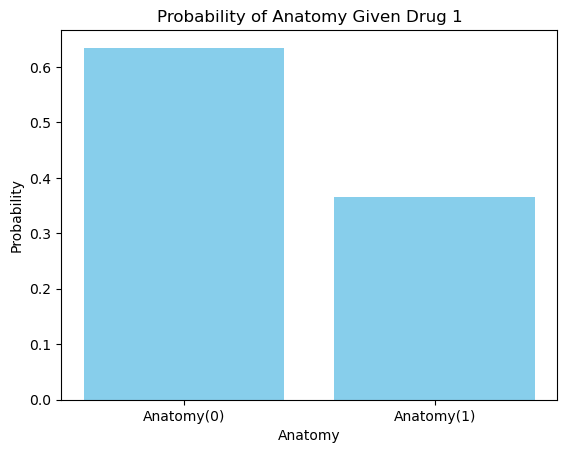

In [134]:
# Visualizing Probability of Anatomy given Drug
probabilities = {'Anatomy(0)': 0.6345, 'Anatomy(1)': 0.3655}
plt.bar(probabilities.keys(), probabilities.values(), color='skyblue')
plt.title("Probability of Anatomy Given Drug 1")
plt.ylabel("Probability")
plt.xlabel("Anatomy")
plt.show()


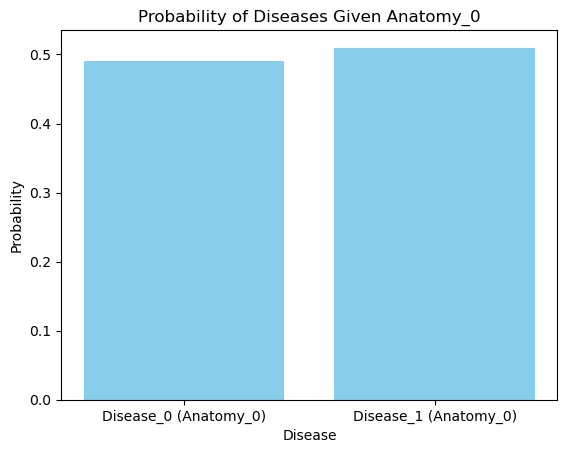

In [135]:
# Visualizing the probabilities
probabilities = {
    'Disease_0 (Anatomy_0)': query_result.values[0],
    'Disease_1 (Anatomy_0)': query_result.values[1]
}
plt.bar(probabilities.keys(), probabilities.values(), color='skyblue')
plt.title("Probability of Diseases Given Anatomy_0")
plt.ylabel("Probability")
plt.xlabel("Disease")
plt.show()

Probability of Drugs given Disease_1:
+---------+-------------+
| Drug    |   phi(Drug) |
+=========+=============+
| Drug(0) |      0.4650 |
+---------+-------------+
| Drug(1) |      0.5350 |
+---------+-------------+


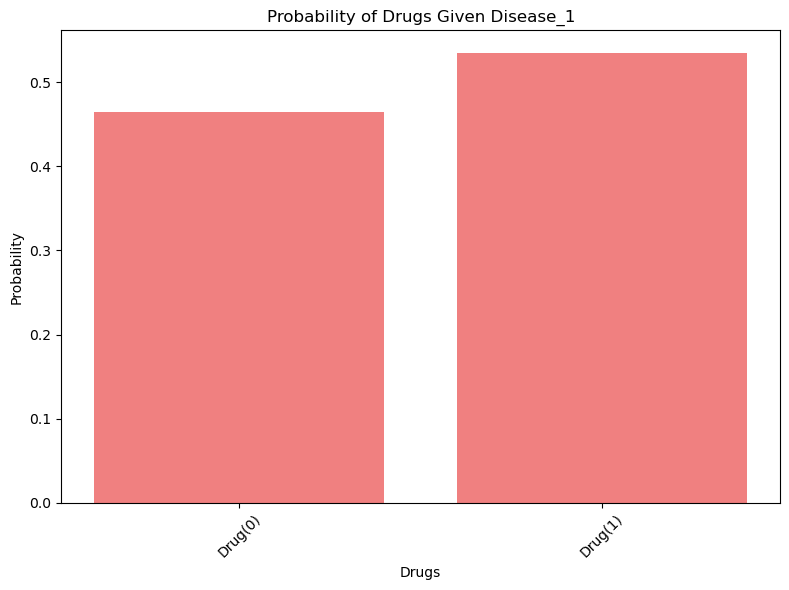

In [136]:
# Probability of a Drug given a Disease
query_result_drug_given_disease = inference.query(variables=['Drug'], evidence={'Disease': 1})

# Displaying the results
print("Probability of Drugs given Disease_1:")
print(query_result_drug_given_disease)

# Correcting the issue with accessing state names
try:
    # Extracting the probability values
    drug_probabilities = query_result_drug_given_disease.values
    
    # Defining drug states explicitly for visualization
    drug_states = ['Drug(0)', 'Drug(1)']

    # Ploting probabilities of drugs given Disease_1
    plt.figure(figsize=(8, 6))
    plt.bar(drug_states, drug_probabilities, color='lightcoral')
    plt.title("Probability of Drugs Given Disease_1")
    plt.xlabel("Drugs")
    plt.ylabel("Probability")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred while plotting: {e}")
